# Imports

In [2]:
import numpy as np
import networkx as nx
import plotly.graph_objects as go 
import gudhi as gd
import matplotlib.pyplot as plt

# Functions

In [4]:
#Inputs: ts - a 2D np array of any shape. Probably a time series. 
# b - the number of bins in each dimension
#Output: bins - A dictionary of arrays that contains the boundaries of the bins in each dimension

def get_bins(ts,b):
    d,n = ts.shape
    bins = {}
    for i in range(d):
        top = max(ts[i,:])
        bot = min(ts[i,:])
        step = (top - bot)/b
        ibins = []
        for j in range(b+1):
            ibins.append(bot+j*step)
        bins[i] = ibins
    return bins

In [5]:
#Inputs: ts - time series
#bins - the partition of each dimension into its bins
#b - number of bins in each dimension

#Output: binseq - a 1D array the length of ts that lists which bin each entry in the time series is in

def bin_sequence(ts, bins, b):
    d,n = ts.shape
    binseq = np.zeros((n))
    for i in range(n):
        bin_n = 0
        for j in range(d):
            k = 1
            while k <= b:
                if ts[j,i] <= bins[j][k]:
                    bin_n += (k-1)*(b**j)
                    k = b + 1
                else: 
                    k = k + 1 
        binseq[i] = bin_n

    return binseq

In [6]:
#inputs: bin-seq - the bin sequence of the time series
#outputs: A - the adjacency matrix
# vertices - the list of vertices, enumerated as bin number

def adjacency(bin_seq, prob = False):
    vertices, counts = np.unique(bin_seq, return_counts=True)
    order = len(vertices)
    A = np.zeros((order,order))
    for i in range(len(bin_seq)-1):
        A[np.where(vertices == bin_seq[i]),np.where(vertices == bin_seq[i+1])] += 1
    if prob:
        A[:,i] = A[:,i]/np.sum(A[:,i])
    return A, vertices, counts

In [7]:
# inputs: A - the adjacency matrix
# vertices - the list of vertices, which are the bin numbers
# loops - whether or not to keep the self-loops in the graph, I am going to do something with this eventually when I include some sort of markovian random walk diffusion distance 
#Output: G - a networkx digraph

def digraph(A, vertices, counts, loops: bool):
    if loops == False:
        np.fill_diagonal(A,0)
        G = nx.DiGraph(A)
    elif loops == True:
        G = nx.DiGraph(A)
    for i in range(len(G.nodes)):
       G.nodes[i]['bin'] = vertices[i]
       G.nodes[i]['count'] = counts[i]

    return G

In [8]:
def bin_centers(bins, b):
    bin_cent = np.zeros((b**3,3))
    for k in range(b):
        for j in range(b):
            for i in range(b):
                bin_cent[k*b**2 + j*b + i,0] += np.mean(bins[0][i:i+2]) 
                bin_cent[k*b**2 + j*b + i,1] += np.mean(bins[1][j:j+2]) 
                bin_cent[k*b**2 + j*b + i,2] += np.mean(bins[2][k:k+2]) 

    return bin_cent

In [9]:
#Inputs: G - a networkx graph
# method - the way you want to measure distance on the graph
# Outputs: D - a distance matrix

def distance_matrix(G, method = 'unweighted_shortest_path'):
    if method == 'unweighted_shortest_path':
        lengths = dict(nx.all_pairs_shortest_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                    D[key,item] = lengths[key][item]
    
    if method == 'probabilistic': #since I doubt we are doing this in this paper, I haven't checked exactly if this is right
        w = nx.get_edge_attributes(G,'weight')
        for key in w:
            w[key] = 1/w[key]
        nx.set_edge_attributes(G,w,name='weight')
        lengths = dict(nx.all_pairs_dijkstra_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                if lengths[key][item] != 0:
                    D[key,item] = lengths[key][item]
                elif lengths[key][item] == 0:
                    D[key,item] = 0

    if method == 'weighted_shortest_path':
        lengths = dict(nx.all_pairs_dijkstra_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                if lengths[key][item] != 0:
                    D[key,item] = lengths[key][item]
                elif lengths[key][item] == 0:
                    D[key,item] = 0

    return D

In [10]:
# This cell is copy-pasted from pyDowker
# by Niklas Hellmer and Jan Spalinski, but only the portion
# that's relevant to our project.
# See https://github.com/nihell/pyDowker


from gudhi import SimplexTree
import numpy as np

class DowkerComplex:
    """
    Class MNeighborComplex. Constructs Dowker's simplicial complex for a relation.
    Filtrations can be added using filtered relations, or total weight, or combining both into a bifiltration.
    """

    def __init__(self, rel_matrix, max_filtration=float('inf')) -> None:
        """_summary_
        Constructor for the filtered Dowker complex from the relations given by sublevels of the matrix rel_matrix.
        The vertices in the complex will correspond to the rows of the matrix.
        
        Parameters
        ----------
        rel_matrix (Sequence[Sequence[float]]): distance matrix (full square or lower triangular).
        max_filtration (float): specifies the maximal filtration value to be considered.      
        """
        self.rel_matrix = rel_matrix
        self.st = None
        
        
     

    def create_simplex_tree(self, 
                            max_dimension, 
                            filtration = 'None', 
                            m=1, 
                            level = 0, 
                            max_filtration = np.inf):
        """
            Creates a gudhi simplex tree storing a skeleton of the (filtered) simpicial complex.
            Uses recursive algorithm with nummpy arrays, fast for small datasets but worse runtime and memory complexity.


        Parameters
        ----------
        max_dimension : int
            Dimension of the skeleton to compute.
        filtration : str, optional
            valid values: "Sublevel", "TotalWeight", "None".
            "Sublevel" takes the filtration of relations by sublevels of the matrix.
            "Total weight" takes the filtration by sublevels of the negative total weight function.
            By default 'None'
        m : int, optional
            restriction to this superlevel of total weight (this is only used if filtration!="TotalWeight"); m=1 corresponds to the whole Dowker complex, by default 1
        level : int, optional
            restriction to this sublevel of the matrix as relation (this is only used if filtration!="Sublevel"), by default 0
        max_filtration : float, optional
            cutoff for the filtration (only used if filtration="Sublevel"), by default np.inf

        Returns
        -------
        gudhi.SimplexTree
            The simplex tree storing the (filtered) simplicial complex
        """
        
        self.st=SimplexTree()


        LAMBDA = self.rel_matrix
        num_points=len(LAMBDA)
        
        if filtration == "Sublevel":
            if LAMBDA.dtype != np.float64:
                raise TypeError("Only float arrays are allowed with sublevel filtration") 
            def append_upper_cofaces(sigma, r, witness_values):
                if r > max_filtration:
                    return
                self.st.insert(sigma,r)
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]

                        j_witness_values=LAMBDA[j,:]
                        common_witness_values = np.maximum(j_witness_values,witness_values)
                        new_r = np.partition(common_witness_values, m-1)[m-1]
                        append_upper_cofaces(tau, new_r, common_witness_values)

            for k in range(num_points-1,-1,-1):
                witness_values = LAMBDA[k,:]
                r_new = np.partition(witness_values, m-1)[m-1]
                append_upper_cofaces([k],r_new,witness_values)
            return self.st
        
        elif filtration == "TotalWeight":
            if LAMBDA.dtype != np.bool_:
                LAMBDA = LAMBDA <= level

            def append_upper_cofaces(sigma, witnesses):
                
                self.st.insert(sigma,-np.sum(witnesses))
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]
                        j_witnesses=LAMBDA[j,:]
                        common_witnesses = np.logical_and(j_witnesses,witnesses)
                        if np.sum(common_witnesses>0):
                            append_upper_cofaces(tau, common_witnesses)

            for k in range(num_points-1,-1,-1):
                witnesses = LAMBDA[k,:]
                append_upper_cofaces([k], witnesses)
            return self.st

        elif filtration == "None":
            if LAMBDA.dtype != np.bool_:
                LAMBDA = LAMBDA <= level

            def append_upper_cofaces(sigma, witnesses):
                if len(witnesses)<m:
                    return
                self.st.insert(sigma)
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]
                        j_witnesses=LAMBDA[j,:]
                        common_witnesses = np.logical_and(j_witnesses,witnesses)
                        if len(common_witnesses>0):
                            append_upper_cofaces(tau, common_witnesses)

            for k in range(num_points-1,-1,-1):
                witnesses = LAMBDA[k,:]
                append_upper_cofaces([k], witnesses)
            return self.st
        
        else:
            raise Exception("filtration parameter must be one of 'Sublevel', 'TotalWeight', 'None'")

In [11]:
def weight_graph(G, weights, smallest, biggest):


    edges = [e for e in G.edges]

    for e in edges:
        source = e[0]
        target = e[1]
        G[source][target]['weight'] = weights(smallest, biggest)

    return G

# For our experiments, we also need to generate synthetic cycle and figure eight graphs, with various directions and weights

## Unweighted Consistently Oriented Cycle

### Hexagon

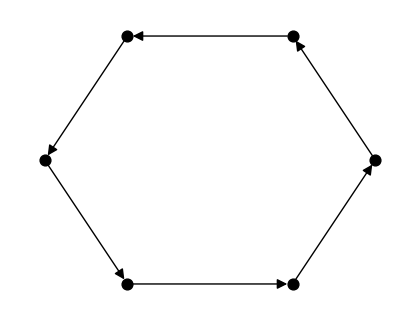

In [223]:
saveFig = 0; # if 1, save; if 0, don't save

# Create cycle graph using networkx
cycleG = nx.cycle_graph(6, create_using=nx.DiGraph)
# Draw cycle graph
pos = nx.circular_layout(cycleG)
plt.figure(figsize=(4, 3)) 
nx.draw(cycleG, pos, edge_color='black', node_size=60, node_color='black', arrowsize=15, width=1)

if saveFig == 1:
    plt.savefig("unwgt_consistcycle_hex.pdf")

In [225]:
# Compute persistence
Dcycle = distance_matrix(cycleG)
cyclecomplex = DowkerComplex(Dcycle).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmcycle = cyclecomplex.persistence()
dgmcycle

[(1, (1.0, 3.0)),
 (0, (0.0, inf)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

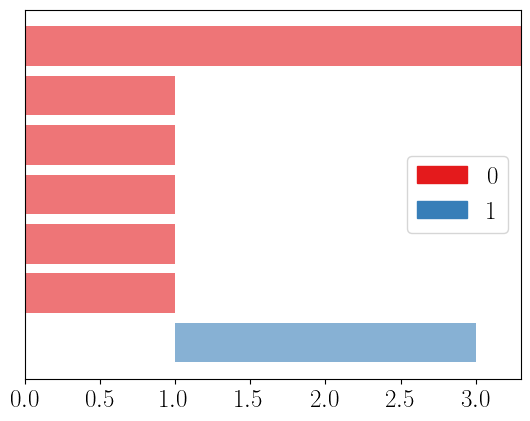

In [227]:
# Corresponding barcode for consistently oriented hexagon
gd.plot_persistence_barcode(dgmcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("unwgt_consistcycle_hex_barcode.pdf")

### Octagon

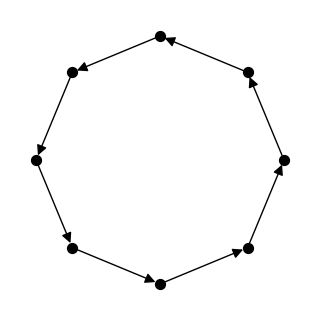

In [229]:
saveFig = 0; # if 1, save; if 0, don't save

# Create cycle graph using networkx
cycleG = nx.cycle_graph(8, create_using=nx.DiGraph)
# Draw cycle graph
pos = nx.circular_layout(cycleG)
plt.figure(figsize=(3, 3)) 
nx.draw(cycleG, pos, edge_color='black', node_size=50, node_color='black', arrowsize=15, width=1)

if saveFig == 1:
    plt.savefig("unwgt_consistcycle_oct.pdf")

In [232]:
# Compute persistence
Dcycle = distance_matrix(cycleG)
cyclecomplex = DowkerComplex(Dcycle).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmcycle = cyclecomplex.persistence()
dgmcycle

[(1, (1.0, 4.0)),
 (0, (0.0, inf)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

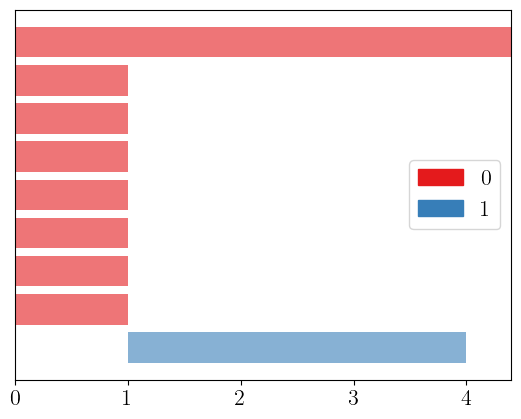

In [234]:
# Corresponding barcode for consistently oriented octagon
gd.plot_persistence_barcode(dgmcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("unwgt_consistcycle_oct_barcode.pdf")

## Weighted Consistently Oriented Cycle

### Hexagon

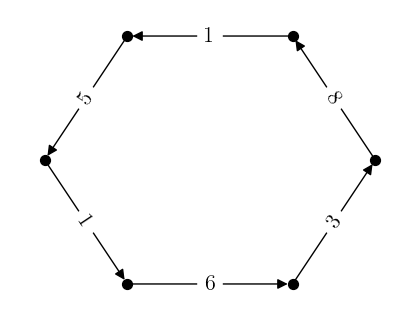

In [238]:
saveFig = 0; # if 1, save; if 0, don't save

# Create graph
cycleG = nx.cycle_graph(6, create_using=nx.DiGraph)
# Assign random weights
pos = nx.circular_layout(cycleG)
weightedcycleG = weight_graph(cycleG, np.random.randint, 1, 10)
edge_labels = nx.get_edge_attributes(weightedcycleG, 'weight')

plt.figure(figsize=(4, 3))
nx.draw(weightedcycleG, pos, node_color='black', node_size=50, edge_color='black', arrowsize=15, width=1)
nx.draw_networkx_edge_labels(weightedcycleG, pos, edge_labels=edge_labels, font_size=16, label_pos=0.5, font_color='black')

if saveFig == 1:
    plt.savefig("wgt_consistcycle_hex.pdf")


In [240]:
# Get distance matrix using weighted shortest path
Dcycleweighted = distance_matrix(weightedcycleG, 'weighted_shortest_path')

# Compute persistence
weightedcyclecomplex = DowkerComplex(Dcycleweighted).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmweightedcycle = weightedcyclecomplex.persistence()
dgmweightedcycle

[(1, (8.0, 12.0)),
 (0, (0.0, inf)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

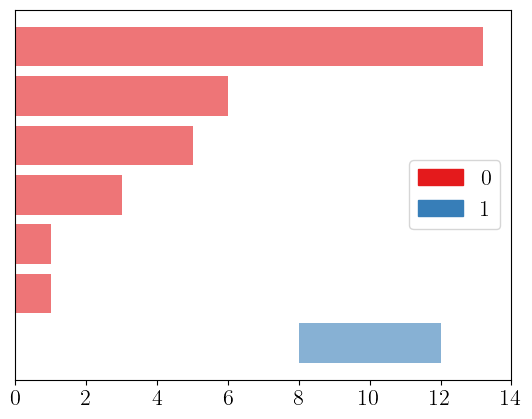

In [242]:
# Corresponding barcode for consistently oriented octagon
gd.plot_persistence_barcode(dgmweightedcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
ax = plt.gca()
xmin, xmax = ax.get_xlim()
plt.xticks(np.arange(0,xmax+2,2))
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("wgt_consistcycle_hex_barcode.pdf")

### Octagon

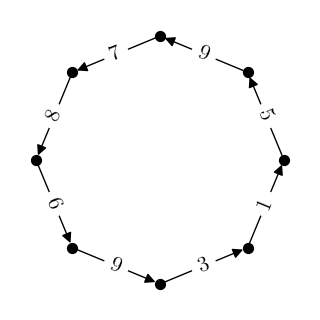

In [245]:
saveFig = 0; # if 1, save; if 0, don't save

# Create graph
cycleG = nx.cycle_graph(8, create_using=nx.DiGraph)
# Assign random weights
pos = nx.circular_layout(cycleG)
weightedcycleG = weight_graph(cycleG, np.random.randint, 1, 10)
edge_labels = nx.get_edge_attributes(weightedcycleG, 'weight')

plt.figure(figsize=(3, 3))
nx.draw(weightedcycleG, pos, node_color='black', node_size=50, edge_color='black', arrowsize=15, width=1)
nx.draw_networkx_edge_labels(weightedcycleG, pos, edge_labels=edge_labels, font_size=16, label_pos=0.5, font_color='black')

if saveFig == 1:
    plt.savefig("wgt_consistcycle_oct.pdf")


In [247]:
# Get distance matrix using weighted shortest path
Dcycleweighted = distance_matrix(weightedcycleG, 'weighted_shortest_path')

# Compute persistence
weightedcyclecomplex = DowkerComplex(Dcycleweighted).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmweightedcycle = weightedcyclecomplex.persistence()
dgmweightedcycle

[(1, (9.0, 24.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 1.0))]

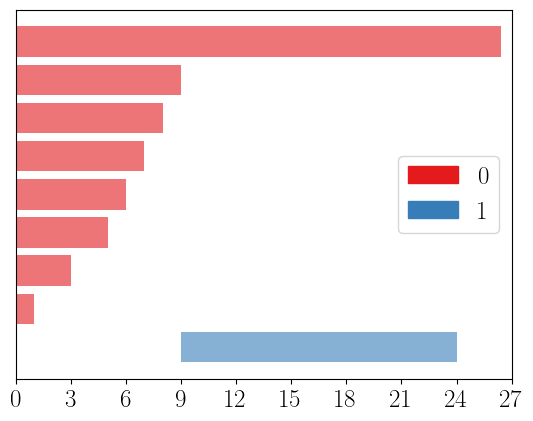

In [249]:
# Corresponding barcode for consistently oriented octagon
gd.plot_persistence_barcode(dgmweightedcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
# Get the x-axis limits
ax = plt.gca()
xmin, xmax = ax.get_xlim()
plt.xticks(np.arange(0,xmax+2,3))
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("wgt_consistcycle_oct_barcode.pdf")

### Consistently-oriented cycle with one large edge

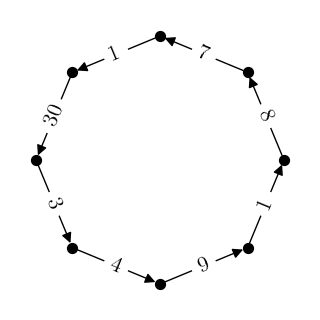

In [217]:
saveFig = 1; # if 1, save; if 0, don't save
# Create graph
cycleG = nx.cycle_graph(8, create_using=nx.DiGraph)

# Assign random weights
pos = nx.circular_layout(cycleG)
weightedcycleG = weight_graph(cycleG, np.random.randint, 1, 10)

# make one edge weight large
largeEdgewt = 30
weightedcycleG.remove_edge(3,4)
weightedcycleG.add_edge(3,4,weight=largeEdgewt)

edge_labels = nx.get_edge_attributes(weightedcycleG, 'weight')

plt.figure(figsize=(3, 3))
nx.draw(weightedcycleG, pos, node_color='black', node_size=50, edge_color='black', arrowsize=15, width=1)
nx.draw_networkx_edge_labels(weightedcycleG, pos, edge_labels=edge_labels, font_size=16, label_pos=0.5, font_color='black')

if saveFig == 1:
    plt.savefig("wgt_consistcycle_oct_largeEdge.pdf")

In [219]:
# Get distance matrix using weighted shortest path
Dcycleweighted = distance_matrix(weightedcycleG, 'weighted_shortest_path')

# Compute persistence
weightedcyclecomplex = DowkerComplex(Dcycleweighted).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmweightedcycle = weightedcyclecomplex.persistence()
dgmweightedcycle

[(1, (30.0, 32.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

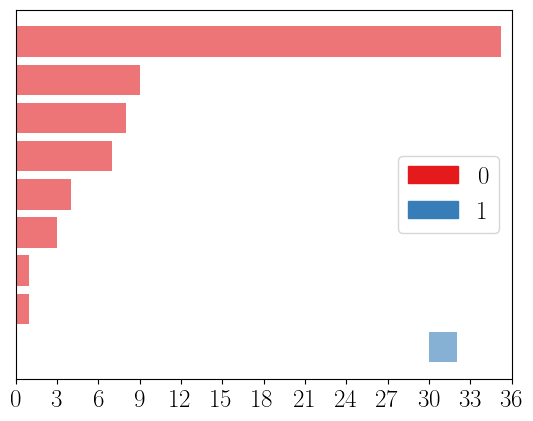

In [221]:
# Corresponding barcode for consistently oriented octagon
gd.plot_persistence_barcode(dgmweightedcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
# Get the x-axis limits
ax = plt.gca()
xmin, xmax = ax.get_xlim()
plt.xticks(np.arange(0,xmax+2,3))
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("wgt_consistcycle_oct_largeEdge_barcode.pdf")

## Not Consistently Oriented, Unweigthed Cycle

### One source, one sink

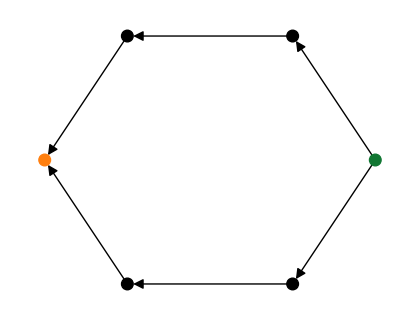

In [337]:
saveFig = 1 # if 1, save; if 0, don't save

# create cycle graph edges and vertices
notcycleG = nx.cycle_graph(6, create_using=nx.DiGraph)
# change orientation of desired edges
notcycleG.remove_edge(3,4)
notcycleG.remove_edge(4,5)
notcycleG.remove_edge(5,0)
notcycleG.add_edge(4,3)
notcycleG.add_edge(5,4)
notcycleG.add_edge(0,5)

# Draw cycle graph
pos = nx.circular_layout(notcycleG)
plt.figure(figsize=(4, 3)) 
# set node colors
nx.set_node_attributes(notcycleG, {0: '#117733', 3: '#ff7f0e'}, name='color')
for node in notcycleG.nodes:
    if 'color' not in notcycleG.nodes[node]:
        notcycleG.nodes[node]['color'] = 'black'
node_colors = [notcycleG.nodes[node]['color'] for node in notcycleG.nodes]
nx.draw(notcycleG, pos, edge_color='black', node_color=node_colors, node_size=70, arrowsize=15, width=1)

if saveFig == 1:
    plt.savefig("unwgt_notcycle_hex_1source1sink.pdf")

In [339]:
# Compute persistence
Dnotcycle = distance_matrix(notcycleG)
notcyclecomplex = DowkerComplex(Dnotcycle).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmnotcycle = notcyclecomplex.persistence()
dgmnotcycle

[(1, (1.0, 3.0)),
 (0, (0.0, inf)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

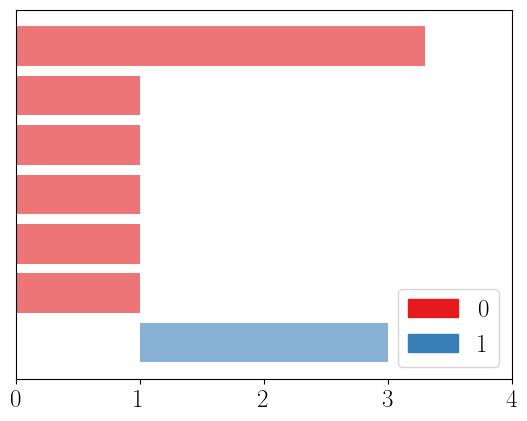

In [341]:
# Corresponding barcode for consistently oriented octagon
gd.plot_persistence_barcode(dgmnotcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
# Get the x-axis limits
ax = plt.gca()
xmin, xmax = ax.get_xlim()
plt.xticks(np.arange(0,xmax+1,1))
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("unwgt_notcycle_hex_1source1sink_barcode.pdf")

## Not Consistently Oriented, Weighted Cycles

### One source, one sink

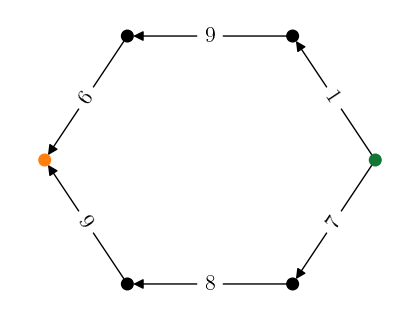

In [329]:
saveFig = 1 # if 1, save; if 0, don't save

# Example with 6 vertices, source at 0, sink at 3
numVerts = 6
notcycleG = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
wtnotcycleG = weight_graph(notcycleG, np.random.randint, 1, 10)

wtnotcycleG.remove_edge(3,4)
wtnotcycleG.remove_edge(4,5)
wtnotcycleG.remove_edge(5,0)
# right now, generating new random weights, but could keep originally generated weights
wtnotcycleG.add_edge(4, 3, weight=np.random.randint(1,10))
wtnotcycleG.add_edge(5,4, weight=np.random.randint(1,10))
wtnotcycleG.add_edge(0,5, weight=np.random.randint(1,10))

# Draw cycle graph
pos = nx.circular_layout(notcycleG)
plt.figure(figsize=(4, 3)) 
edge_labels = nx.get_edge_attributes(wtnotcycleG, 'weight')
# set node colors
nx.set_node_attributes(notcycleG, {0: '#117733', 3: '#ff7f0e'}, name='color')
for node in notcycleG.nodes:
    if 'color' not in notcycleG.nodes[node]:
        notcycleG.nodes[node]['color'] = 'black'
node_colors = [notcycleG.nodes[node]['color'] for node in notcycleG.nodes]

nx.draw(wtnotcycleG, pos, edge_color='black', node_color=node_colors, node_size=70, arrowsize=15, width=1)
nx.draw_networkx_edge_labels(wtnotcycleG, pos, edge_labels=edge_labels, font_size=16, label_pos=0.5, font_color='black')

if saveFig == 1:
    plt.savefig("wgt_notcycle_hex_1source1sink.pdf")

In [331]:
# Get distance matrix using weighted shortest path
DwtnotcycleG = distance_matrix(wtnotcycleG, method='weighted_shortest_path')

# Compute persistence
wtnotcyclecomplex = DowkerComplex(DwtnotcycleG).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmwtnotcycle = wtnotcyclecomplex.persistence()
dgmwtnotcycle

[(1, (9.0, 16.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 1.0))]

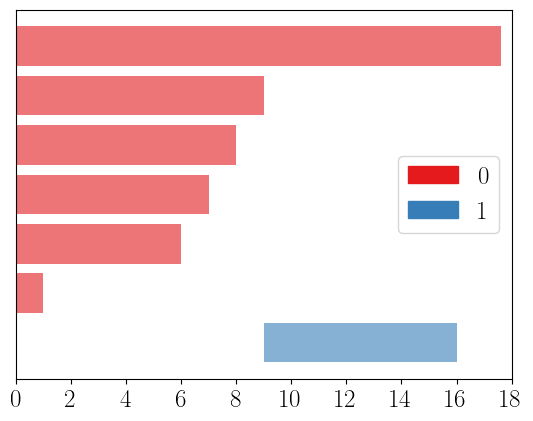

In [333]:
# Corresponding barcode for consistently oriented octagon
gd.plot_persistence_barcode(dgmwtnotcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
ax = plt.gca()
xmin, xmax = ax.get_xlim()
plt.xticks(np.arange(0,xmax+2,2))
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("wgt_notcycle_hex_1source1sink_barcode.pdf")

### Lots of sources
<p>Even number of vertices; every other vertex a source</p>
<p>Should have one cycle persist indefinitely.</p>

In [49]:
# Example with numVerts vertices, every other is source/sink
numVerts = 16 # make even for alternating
G = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
G = weight_graph(G, np.random.randint, 1, 10)

weightDict = nx.get_edge_attributes(G, 'weight')

for k in range(1, numVerts+1, 2):
    node1 = k
    node2 = (k+1)%numVerts
    
    current_weight = weightDict[(node1, node2)]
    
    G.remove_edge(node1, node2)
    G.add_edge(node2, node1, weight=current_weight)

{(0, 1): Text(0.9619392757783265, 0.19134411689964148, '4'),
 (0, 15): Text(0.9619393055810219, -0.1913441134221887, '6'),
 (2, 3): Text(0.5448888936925929, 0.8154972832954108, '5'),
 (2, 1): Text(0.8154914212690914, 0.544897672507827, '1'),
 (4, 5): Text(-0.19133825149136108, 0.9619404592783267, '7'),
 (4, 3): Text(0.19133824900485963, 0.9619404294765439, '3'),
 (6, 7): Text(-0.8154914098451964, 0.5448976874087523, '6'),
 (6, 5): Text(-0.5448888524652333, 0.8154973130988763, '7'),
 (8, 9): Text(-0.9619392643544323, -0.19134417203437737, '4'),
 (8, 7): Text(-0.9619392643544323, 0.1913440880901487, '4'),
 (10, 11): Text(-0.5448889716768082, -0.8154972351146613, '3'),
 (10, 9): Text(-0.8154914396479906, -0.5448976541289275, '8'),
 (12, 13): Text(0.19133833642706333, -0.9619404110986554, '5'),
 (12, 11): Text(-0.19133831307807236, -0.9619404110986554, '9'),
 (14, 15): Text(0.8154913914653528, -0.5448977286363849, '3'),
 (14, 13): Text(0.544888893697165, -0.8154973245181989, '8')}

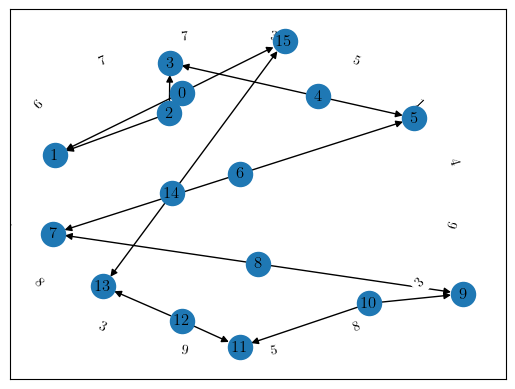

In [50]:
nx.draw_networkx(G)
pos=nx.circular_layout(G) # was spring_layout(G)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [51]:
DwtnotcycleG = distance_matrix(G, method='weighted_shortest_path')

In [52]:
DwtnotcycleG

array([[   0.,    4., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000.,    6.],
       [1000.,    0., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [1000.,    1.,    0.,    5., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [1000., 1000., 1000.,    0., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [1000., 1000., 1000.,    3.,    0.,    7., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [1000., 1000., 1000., 1000., 1000.,    0., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [1000., 1000., 1000., 1000., 1000.,    7.,    0.,    6., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [1000., 1000., 1000., 1000., 1000., 1000., 1000.,    0., 1000.,
        1000., 1000., 1000

In [53]:
wtnotcyclecomplex = DowkerComplex(DwtnotcycleG).create_simplex_tree(filtration='Sublevel', max_dimension=2)

In [54]:
dgmwtnotcycle = wtnotcyclecomplex.persistence()

In [55]:
dgmwtnotcycle # One cycle persists indefinitely!

[(1, (9.0, 1000.0)),
 (0, (0.0, inf)),
 (0, (0.0, 8.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 1.0))]

### Two opposing sources

In [57]:
# Example with 22 vertices, sources at 0 and 11, sinks at 4 and 18
numVerts = 22
source1 = 0
sink1 = 4
source2 = 11
sink2 = 18
Gtwosource = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
Gtwosource = weight_graph(Gtwosource, np.random.randint, 1, 10)

weightDict = nx.get_edge_attributes(Gtwosource, 'weight')

# Swap direction between sink1 and source2
for k in range(sink1, source2, 1):
    node1 = k
    node2 = (k+1)%numVerts
    
    current_weight = weightDict[(node1, node2)] # keeping current weights; could generate new random weights
    
    Gtwosource.remove_edge(node1, node2)
    Gtwosource.add_edge(node2, node1, weight=current_weight)

# Swap direction between sink2 and source1
for k in range(sink2, numVerts, 1):
    node1 = k
    node2 = (k+1)%numVerts
    
    current_weight = weightDict[(node1, node2)] # keeping current weights; could generate new random weights
    
    Gtwosource.remove_edge(node1, node2)
    Gtwosource.add_edge(node2, node1, weight=current_weight)


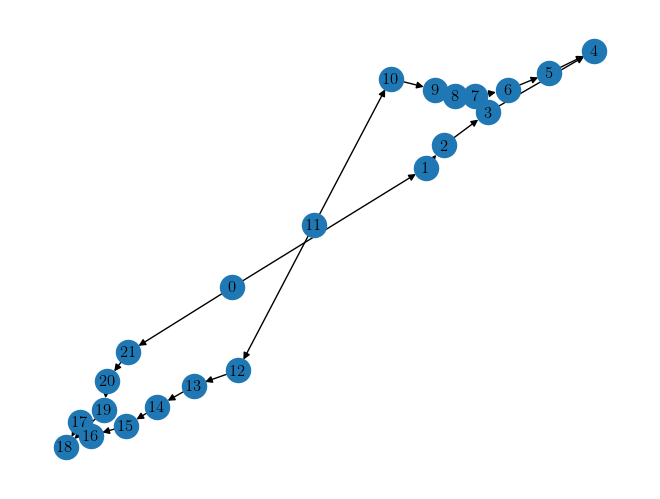

In [58]:
nx.draw(Gtwosource, with_labels="True")

{(0, 1): Text(0.024154778189089177, 0.29075131240424956, '2'),
 (0, 21): Text(-0.3512561098810222, -0.315981455149947, '7'),
 (1, 2): Text(0.3019735194979434, 0.722433947422447, '5'),
 (2, 3): Text(0.38897603077349174, 0.8709295345971251, '3'),
 (3, 4): Text(0.48874158508787313, 0.9911903638024537, '5'),
 (5, 4): Text(0.5107020230424353, 0.9706929924190455, '5'),
 (6, 5): Text(0.5192601757313773, 0.9385464517639934, '7'),
 (7, 6): Text(0.5430134307707271, 0.8778289402957162, '6'),
 (8, 7): Text(0.514588271903341, 0.7373706262096358, '9'),
 (9, 8): Text(0.4873878091637036, 0.608549410129019, '8'),
 (10, 9): Text(0.5114635546959425, 0.5157792032633508, '2'),
 (11, 12): Text(-0.05700432250499965, -0.385826395029802, '8'),
 (11, 10): Text(0.3428979487740058, 0.183854262424622, '8'),
 (12, 13): Text(-0.3144430686241151, -0.6833233632868047, '2'),
 (13, 14): Text(-0.3994391827212521, -0.7113991163337601, '7'),
 (14, 15): Text(-0.43794744928664087, -0.7715763662866089, '7'),
 (15, 16): Text(-

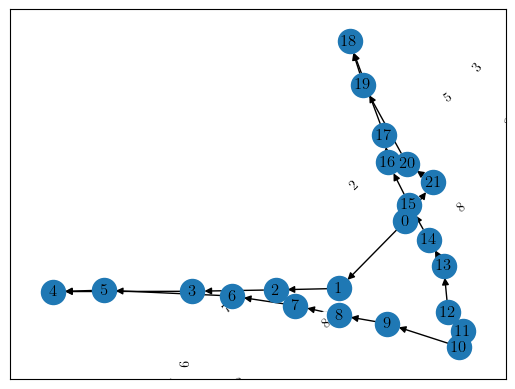

In [59]:
nx.draw_networkx(Gtwosource)
pos=nx.spring_layout(Gtwosource)
labels = nx.get_edge_attributes(Gtwosource,'weight')
nx.draw_networkx_edge_labels(Gtwosource,pos,edge_labels=labels)

In [60]:
Dtwosource = distance_matrix(Gtwosource, method='weighted_shortest_path')
complextwosource = DowkerComplex(Dtwosource).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmtwosource = complextwosource.persistence()
dgmtwosource

[(1, (9.0, 45.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0))]

### One source and one sink source, one edge with large weight

In [62]:
# Example with 12 vertices, sink at 0, source at 6, large weight on edge (5,4)
numVerts = 12
notcycleG = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
Glrgwt = weight_graph(notcycleG, np.random.randint, 1, 10)

source = 6
sink = 0

weightDict = nx.get_edge_attributes(Glrgwt, 'weight')

# Swap direction between sink1 and source2
for k in range(sink, source, 1):
    node1 = k
    node2 = (k+1)%numVerts
    
    current_weight = weightDict[(node1, node2)] # keeping current weights; could generate new random weights
    
    Glrgwt.remove_edge(node1, node2)
    Glrgwt.add_edge(node2, node1, weight=current_weight)

# Replace one edge with large weight
Glrgwt.remove_edge(5,4)
Glrgwt.add_edge(5,4,weight=200)

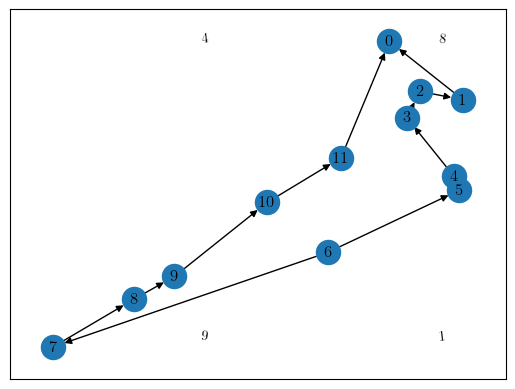

In [63]:
nx.draw_networkx(Glrgwt)
pos=nx.circular_layout(Glrgwt) # was nx.spring_layout
labels = nx.get_edge_attributes(Glrgwt,'weight')
nx.draw_networkx_edge_labels(Glrgwt,pos,edge_labels=labels)
plt.show()

In [64]:
DwtnotcycleG = distance_matrix(wtnotcycleG, method='weighted_shortest_path')

In [65]:
DwtnotcycleG

array([[   0.,    8.,    9.,   16.,   13.,    8.],
       [1000.,    0.,    1.,    9., 1000., 1000.],
       [1000., 1000.,    0.,    8., 1000., 1000.],
       [1000., 1000., 1000.,    0., 1000., 1000.],
       [1000., 1000., 1000.,    3.,    0., 1000.],
       [1000., 1000., 1000.,    8.,    5.,    0.]])

In [66]:
wtnotcyclecomplex = DowkerComplex(DwtnotcycleG).create_simplex_tree(filtration='Sublevel', max_dimension=2)

In [67]:
dgmwtnotcycle = wtnotcyclecomplex.persistence()

In [68]:
dgmwtnotcycle

[(1, (8.0, 16.0)),
 (0, (0.0, inf)),
 (0, (0.0, 8.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 1.0))]